# Домашка 
---------------------------------------

tldr:
    
* Выбрать архитектуру из рассказанных NST, pix2pix, CycleGAN$^1$
* Подберите к ней задачу, чтобы она вам нравилась
* Подберите еще одну задачу, которая уже решена (если не NST)
* Повторите решение, которое уже есть$^2$ (если не NST)
* Решите свою задачу

---------------------------------------
1. Расположены в порядке возрастания сложности и крутизны
2. Поверьте если вы сделаете этот пункт следующий будет в *разы* легче

## Если вы выбрали Neural Style Transfer
---------------------------------------
Тут все довольно просто на первый и на второй взгляд. Поэтому недосотаточно просто написать свою функцию потерь и сдать ноутбук. Если вы хотите приличных баллов, то у вас есть две опции:


1. Вы разделяете картинку на две части и переносите на них разные стили. <p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала к одной чати картинки, а потом к другой.</span></p> От вас ожидается, что вы отдадите нейросети два картинки стиля и она внутри себя(скорее внутри лосс функции) разделит выходную картинку на две части и к одной части применит один стиль, а к другой - второй. 

2. Вы переносите *одновременно* два стиля на одну картинку контента.
<p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала с одним стилем, а потом с другим.</span></p>
От вас ожидается, что вы модифицируете модель(скорее лосс модели) для того, чтобы два стиля учитывались с разными весами. 

## Если вы выбрали pix2pix
---------------------------------------------
Здесь от вас ожидается, что вы реализуете свою архитектуру для pix2pix модели. Пожалуйста не копируйте код из открытых репозиториев. Этот факт очень легко обнаружить. Перед тем, как приступить проверьте, что обе задачи, которые вы выбрали влезают на вашу видеокарту или на карту Google Colab. Если они не влезают, но вам все равно очень хочется, то вы можете израсходовать все безплатные триалы облаков(Google, Amazon, .. etc) во вселенной. 

## Если вы выбрали CycleGAN
--------------------------------------------
Здесь от вас ожидается, что вы реализуете свою архитектуру для CycleGAN модели. Пожалуйста не копируйте код из открытых репозиториев. Этот факт очень легко обнаружить. Перед тем, как приступить проверьте, что обе задачи, которые вы выбрали влезают на вашу видеокарту или на карту Google Colab. CycleGAN в этом смысле хуже, чем pix2pix, он ест больше памяти. Если они не влезают, но вам все равно очень хочется, то вы можете израсходовать все беcплатные триалы облаков(Google, Amazon, .. etc) во вселенной. 

## Remarks:
-----------------------------------------

* Это задание нужно для того, чтобы вы наступили на все грабли, что есть. Узнали об их существовании и научились обходить. Посмотрели на неработающие модели и поняли, что все тлен. Изгуглили весь интернет и в конце заставили это все работать. Поверьте, оно того стиот. Не откладывайте это задание на ночь перед сдачей, так как весь смысл \*пуф\* улетучится.

* У вас два союзника в этой борьбе:
    1. Оригинальная статья, те психи, что ее писала как то заставили свою модель работать. Их мысли, которыми они спроводили свое детище, позволят вам написать свой вариант алгоритма. 
    2. Гугл, он знает ответы на почти все ваши вопросы, но у него есть две ипостаси одна простая в обещении и вы все ее занаете(русскоязычная), а есть еще одна, которая кусается, но знает больше(англоязычная). Если не знаете языва - учите на ходу :)
    
* На самом деле у вас есть еще один союзник, это ментор проекта (или лектор или семинарист). Его ресурсом нужно пользоваться в ситуации, в которой вы не можете(занчит попытались и не вышло) найти ответов, используя Гугл и статью.

* Сдавать это все нужно следующим образом. Код вы кидаете на github и отправляете ссылку туда, куда вам сказали(в телеграм, степик или еще куда-то)

Для реализации я выбрала CycleGAN, потому что он показался мне более понятным (в некотором смысле), более интересным 
(всегда хотела генерировать кошечек в собачек) и простым в плане составления датасета.

Сначала я попробовала обучить на зебрах и лошадках оригинальную имплементацию 
[отсюда](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix). 
В проект я не буду копировать этот репозиторий целиком, только мои результаты обучения. 

В качестве своей задачи я выбрала перенос стиля комикса на фото. 

[Оригинальный пейпер](https://arxiv.org/pdf/1703.10593.pdf)

In [2]:
import os
import glob
import time
import random
import itertools

import torch
import torch.nn as nn
import torch.nn.parallel

import torch.utils.data
from torch.utils.data import Dataset

import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

In [0]:
# Set random seed for reproducibility
seed = 15
random.seed(seed)
torch.manual_seed(seed);

Очень страшный код:

In [0]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),

            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(self, channels, num_blocks=9):
        super(Generator, self).__init__()
        self.channels = channels

        model = [nn.ReflectionPad2d(3)]
        model += self._create_layer(self.channels, 64, 7, stride=1, padding=0, transposed=False)
        # downsampling
        model += self._create_layer(64, 128, 3, stride=2, padding=1, transposed=False)
        model += self._create_layer(128, 256, 3, stride=2, padding=1, transposed=False)

        # residual blocks
        model += [ResidualBlock(256) for _ in range(num_blocks)]

        # upsampling
        model += self._create_layer(256, 128, 3, stride=2, padding=1, transposed=True)
        model += self._create_layer(128, 64, 3, stride=2, padding=1, transposed=True)
        
        # output
        model += [nn.ReflectionPad2d(3),
                  nn.Conv2d(64, self.channels, 7),
                  nn.Tanh()]

        self.model = nn.Sequential(*model)

    def _create_layer(self, size_in, size_out, kernel_size, stride=2, padding=1, transposed=False):
        layers = []
        if transposed:
            layers.append(nn.ConvTranspose2d(size_in, size_out, kernel_size, stride=stride, padding=padding, output_padding=1))
        else:
            layers.append(nn.Conv2d(size_in, size_out, kernel_size, stride=stride, padding=padding))
        layers.append(nn.InstanceNorm2d(size_out))
        layers.append(nn.ReLU(inplace=True))
        return layers

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        self.channels = channels

        self.model = nn.Sequential(
            *self._create_layer(self.channels, 64, 2, normalize=False),
            *self._create_layer(64, 128, 2),
            *self._create_layer(128, 256, 2),
            *self._create_layer(256, 512, 1),
            nn.Conv2d(512, 1, 4, stride=1, padding=1)
        )

    def _create_layer(self, size_in, size_out, stride, normalize=True):
        layers = [nn.Conv2d(size_in, size_out, 4, stride=stride, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(size_out))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, x):
        return self.model(x)

In [0]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, unaligned=False, mode='train'):
        self.transform = transform
        self.unaligned = unaligned
        self.train = (mode == 'train')

        self.files_A = sorted(glob.glob(os.path.join(root_dir, '%sA' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root_dir, '%sB' % mode) + '/*.*'))

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]).convert('RGB'))

        if self.unaligned:
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]))
        else:
            item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]))

        if self.train:
            return {'trainA': item_A, 'trainB': item_B}
        else:
            return {'testA': item_A, 'testB': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
transform=transforms.Compose([transforms.Resize(128),
                              transforms.CenterCrop(128),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

dataloader = torch.utils.data.DataLoader(ImageDataset('datasets/img2comics',
                                                      transform=transform, unaligned=True, mode='train'),
                                         batch_size=4, shuffle=True, num_workers=4)

test_dataloader = torch.utils.data.DataLoader(ImageDataset('datasets/img2comics',
                                                           transform=transform, unaligned=True, mode='test'),
                                              batch_size=4, shuffle=True, num_workers=4)

In [0]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

Посмотрим на картинки:

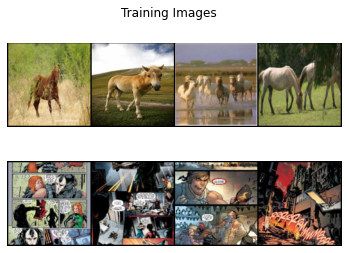

In [0]:
real_batch = next(iter(dataloader))
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Training Images')

ax1.imshow(np.transpose(vutils.make_grid(real_batch['trainA'].to(device), padding=2, normalize=True).cpu(), (1, 2, 0)))
ax1.axis("off")

ax2.imshow(np.transpose(vutils.make_grid(real_batch['trainB'].to(device), padding=2, normalize=True).cpu(), (1, 2, 0)))
ax2.axis("off");

Подготовим части сетки:

In [0]:
netG_AB = Generator(3, 9)
netG_AB.apply(weights_init)
netG_AB.to(device)

netG_BA = Generator(3, 9)
netG_BA.apply(weights_init)
netG_BA.to(device)

netD_A = Discriminator(3)
netD_A.apply(weights_init)
netD_A.to(device)

netD_B = Discriminator(3)
netD_B.apply(weights_init)
netD_B.to(device);

In [0]:
alpha = 0.5 
beta = 0.999
lr = 2e-4

optim_G = torch.optim.Adam(itertools.chain(netG_AB.parameters(), netG_BA.parameters()),
                           lr=lr, betas=(alpha, beta))

optim_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr, betas=(alpha, beta))

optim_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr, betas=(alpha, beta))

loss_adv = torch.nn.MSELoss()
loss_cyc = torch.nn.L1Loss()
loss_iden = torch.nn.L1Loss()

In [0]:
def save_to(path='', name='CycleGAN', verbose=True):
        if verbose:
            print('\nSaving models to {}_G_AB.pt and such ...'.format(name))
        torch.save(netG_AB.state_dict(), os.path.join(path, '{}_G_AB.pt'.format(name)))
        torch.save(netG_BA.state_dict(), os.path.join(path, '{}_G_BA.pt'.format(name)))
        torch.save(netD_A.state_dict(), os.path.join(path, '{}_D_A.pt'.format(name)))
        torch.save(netD_B.state_dict(), os.path.join(path, '{}_D_B.pt'.format(name)))

In [0]:
class ImageBuffer(object):
    def __init__(self, depth=50):
        self.depth = depth
        self.buffer = []

    def update(self, image):
        if len(self.buffer) == self.depth:
            i = random.randint(0, self.depth-1)
            self.buffer[i] = image
        else:
            self.buffer.append(image)
        if random.uniform(0,1) > 0.5:
            i = random.randint(0, len(self.buffer)-1)
            return self.buffer[i]
        else:
            return image

In [0]:
netG_AB.train()
netG_BA.train()
netD_A.train()
netD_B.train()

num_epochs = 100
lambda_iden = 5
lambda_cyc = 10
log_interval = 100

out_dir = 'img2comics/res'
name = 'first_try'

image_buffer_A = ImageBuffer()
image_buffer_B = ImageBuffer()

total_time = time.time()

print("Starting Training Loop...")
for epoch in range(num_epochs):
    batch_time = time.time()
    for batch_idx, data in enumerate(dataloader):
        real_A = data['trainA'].to(device)
        real_B = data['trainB'].to(device)

        real_label = torch.ones((len(real_A), 1, 14, 14), device=device)
        fake_label = torch.zeros((len(real_B), 1, 14, 14), device=device)

        # Train G
        optim_G.zero_grad()

        # adversarial loss
        fake_B = netG_AB(real_A)
        _loss_adv_AB = loss_adv(netD_B(fake_B), real_label)
        fake_A = netG_BA(real_B)
        _loss_adv_BA = loss_adv(netD_A(fake_A), real_label)
        adv_loss = (_loss_adv_AB + _loss_adv_BA) / 2

        # cycle loss
        recov_A = netG_BA(fake_B)
        _loss_cyc_A = loss_cyc(recov_A, real_A)
        recov_B = netG_AB(fake_A)
        _loss_cyc_B = loss_cyc(recov_B, real_B)
        cycle_loss = (_loss_cyc_A + _loss_cyc_B) / 2

        # identity loss
        _loss_iden_A = loss_iden(netG_BA(real_A), real_A)
        _loss_iden_B = loss_iden(netG_AB(real_B), real_B)
        iden_loss = (_loss_iden_A + _loss_iden_B) / 2

        g_loss = adv_loss + lambda_cyc * cycle_loss + lambda_iden * iden_loss
        g_loss.backward()
        optim_G.step()

        # Train D_A
        optim_D_A.zero_grad()

        real_label = torch.ones((len(netD_A(real_A)), 1, 14, 14), device=device)

        _loss_real = loss_adv(netD_A(real_A), real_label)
        fake_A = image_buffer_A.update(fake_A)
        fake_label = torch.zeros((len(netD_A(fake_A.detach())), 1, 14, 14), device=device)
        _loss_fake = loss_adv(netD_A(fake_A.detach()), fake_label)
        d_loss_A = (_loss_real + _loss_fake) / 2

        d_loss_A.backward()
        optim_D_A.step()

        # Train D_B
        optim_D_B.zero_grad()

        real_label = torch.ones((len(netD_B(real_B)), 1, 14, 14), device=device)

        _loss_real = loss_adv(netD_B(real_B), real_label)
        fake_B = image_buffer_B.update(fake_B)
        fake_label = torch.zeros((len(netD_B(fake_B.detach())), 1, 14, 14), device=device)
        _loss_fake = loss_adv(netD_B(fake_B.detach()), fake_label)
        d_loss_B = (_loss_real + _loss_fake) / 2

        d_loss_B.backward()
        optim_D_B.step()

        d_loss = (d_loss_A + d_loss_B) / 2

        if batch_idx % log_interval == 0 and batch_idx > 0:
            print('Epoch {} [{}/{}] loss_D: {:.4f} loss_G: {:.4f} time: {:.2f}'.format(
                    epoch, batch_idx, len(dataloader),
                    d_loss.mean().item(),
                    g_loss.mean().item(),
                    time.time() - batch_time))
            with torch.no_grad():
                imgs = next(iter(test_dataloader))
                _real_A = imgs['testA'].to(device)
                _fake_B = netG_AB(_real_A)
                _real_B = imgs['testB'].to(device)
                _fake_A = netG_BA(_real_B)
                viz_sample = torch.cat((_real_A, _fake_B, _real_B, _fake_A), 0)
                vutils.save_image(viz_sample,
                                    os.path.join(out_dir, 'samples_{}_{}.png'.format(epoch, batch_idx)),
                                    nrow=test_dataloader.batch_size,
                                    normalize=True)
            batch_time = time.time()

    save_to(path=out_dir, name=name, verbose=False)

print('Total train time: {:.2f}'.format(time.time() - total_time))

Starting Training Loop...
Epoch 0 [100/280] loss_D: 0.1083 loss_G: 2.9668 time: 62.66
Epoch 0 [200/280] loss_D: 0.1432 loss_G: 2.8739 time: 60.94
Epoch 1 [100/280] loss_D: 0.1008 loss_G: 2.8203 time: 61.96
Epoch 1 [200/280] loss_D: 0.1865 loss_G: 2.3377 time: 61.23
Epoch 2 [100/280] loss_D: 0.1861 loss_G: 3.0345 time: 62.02
Epoch 2 [200/280] loss_D: 0.1701 loss_G: 3.5029 time: 61.14
Epoch 3 [100/280] loss_D: 0.0920 loss_G: 2.9833 time: 62.09
Epoch 3 [200/280] loss_D: 0.1141 loss_G: 2.6047 time: 61.08
Epoch 4 [100/280] loss_D: 0.1442 loss_G: 2.3876 time: 62.06
Epoch 4 [200/280] loss_D: 0.1536 loss_G: 2.8707 time: 61.19
Epoch 5 [100/280] loss_D: 0.1167 loss_G: 2.4303 time: 62.20
Epoch 5 [200/280] loss_D: 0.1512 loss_G: 2.9811 time: 61.00
Epoch 6 [100/280] loss_D: 0.1836 loss_G: 2.3969 time: 62.08
Epoch 6 [200/280] loss_D: 0.1263 loss_G: 2.5652 time: 61.18
Epoch 7 [100/280] loss_D: 0.1478 loss_G: 2.2345 time: 62.13
Epoch 7 [200/280] loss_D: 0.1599 loss_G: 2.6203 time: 61.13
Epoch 8 [100/2

*Сравнение двух сеток получилось не очень корректным, потому что обучались сетки на разных устройствах 
и я не уследила за этим 👀*

Результаты оригинальной имплементации (картинки размера 128х128, со планировщиком, 128 эпох):

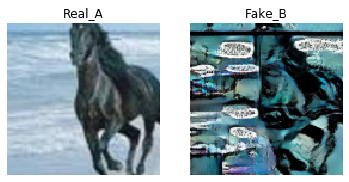

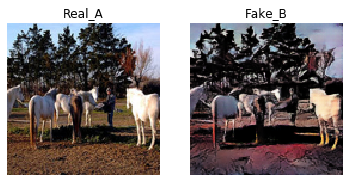

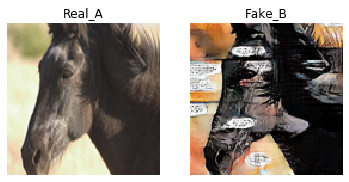

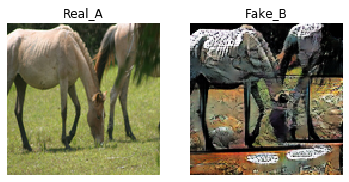

In [29]:
items = [
    ('pytorch-CycleGAN-and-pix2pix/checkpoints/comic_128to400/web/images/epoch118_real_A.png',
     'pytorch-CycleGAN-and-pix2pix/checkpoints/comic_128to400/web/images/epoch118_fake_B.png'),
    
    ('pytorch-CycleGAN-and-pix2pix/checkpoints/comic_128to400/web/images/epoch116_real_A.png',
     'pytorch-CycleGAN-and-pix2pix/checkpoints/comic_128to400/web/images/epoch116_fake_B.png'),
    
    ('pytorch-CycleGAN-and-pix2pix/checkpoints/comic_128to400/web/images/epoch111_real_A.png',
     'pytorch-CycleGAN-and-pix2pix/checkpoints/comic_128to400/web/images/epoch111_fake_B.png'),
    
    ('pytorch-CycleGAN-and-pix2pix/checkpoints/comic_128to400/web/images/epoch110_real_A.png',
     'pytorch-CycleGAN-and-pix2pix/checkpoints/comic_128to400/web/images/epoch110_fake_B.png'),
]

for realA_img, fakeB_img in items:
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(Image.open(realA_img))
    ax1.set_title('Real_A')
    ax1.axis("off")

    ax2.imshow(Image.open(fakeB_img))
    ax2.set_title('Fake_B')
    ax2.axis("off")
plt.show()

Мои результаты (128х128, без планировщика, 100 эпох):

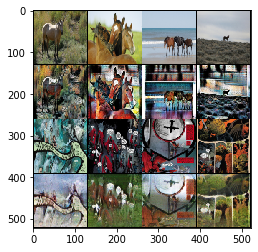

In [28]:
image = Image.open('img2comics/res/samples_99_200.png')
imgplot = plt.imshow(image)
